## Energy Consumption 데이터 셋

In [ ]:
import os
import time
import numpy as np
import copy
import torch
import torch.nn as nn
import pandas as pd

In [ ]:
df = pd.read_csv('drive/MyDrive/energy_daily.csv')

In [ ]:
df

,Date,W
0,2017-01-02,113884.376756
1,2017-01-03,115749.403766
2,2017-01-04,114738.968744
3,2017-01-05,113232.581490
4,2017-01-06,108208.275373
...,...,...
611,2018-09-30,101137.446320
612,2018-10-01,137820.726257
613,2018-10-02,123416.719997
614,2018-10-03,134916.629228


In [ ]:
df=df['W']
print(df.max())
print(df.min())

264139.990829977
77824.75667106088


In [ ]:
df = (df - df.min())/(df.max() - df.min()) #model normalizes

In [ ]:
print(df)

0      0.193541
1      0.203551
2      0.198128
3      0.190043
4      0.163076
         ...   
611    0.125125
612    0.322013
613    0.244703
614    0.306426
615    0.322856
Name: W, Length: 616, dtype: float64


## 30개씩 담아주기 (Monthly) - optional 

In [ ]:
values = df.values

data = []
seq_len = 30
for i in range(len(values)-seq_len+1):
     #print(list(values[i:i+seq_len]))
     data.append(list(values[i:i+seq_len].reshape(-1)))
     if i==1:
         print(data)


df = pd.DataFrame(data)

print(df.info())

[[0.19354091063975745, 0.20355097244697024, 0.19812771746643917, 0.1900425640359459, 0.16307586891295162, 0.06904344583091582, 0.0349570923860602, 0.18012760270677525, 0.16469125395599923, 0.1487028859530828, 0.13743477929044826, 0.13301559374037872, 0.04964268971900893, 0.05406299437634862, 0.1419951607873467, 0.1985550586069767, 0.22165209785749193, 0.20904763565993031, 0.19524222575199546, 0.08167776950938133, 0.07355531421064455, 0.23949093765982468, 0.2645567593282403, 0.25473748957669723, 0.12338500831118433, 0.22040655473013002, 0.13140647904254613, 0.1355104752293138, 0.2633459623846408, 0.26805843375519817], [0.20355097244697024, 0.19812771746643917, 0.1900425640359459, 0.16307586891295162, 0.06904344583091582, 0.0349570923860602, 0.18012760270677525, 0.16469125395599923, 0.1487028859530828, 0.13743477929044826, 0.13301559374037872, 0.04964268971900893, 0.05406299437634862, 0.1419951607873467, 0.1985550586069767, 0.22165209785749193, 0.20904763565993031, 0.19524222575199546, 0

In [ ]:
print(len(df))

587


## Else (Daily ver.)

In [ ]:
train_df = pd.DataFrame(df[:int(0.8*len(df))])
print(train_df)

            W
0    0.193541
1    0.203551
2    0.198128
3    0.190043
4    0.163076
..        ...
487  0.338293
488  0.341567
489  0.207684
490  0.196879
491  0.438719

[492 rows x 1 columns]


In [ ]:
test_df = pd.DataFrame(df[int(0.8*len(df)):])
print(test_df)

            W
492  0.394864
493  0.380429
494  0.393407
495  0.412288
496  0.226514
..        ...
611  0.125125
612  0.322013
613  0.244703
614  0.306426
615  0.322856

[124 rows x 1 columns]


In [ ]:
train = train_df.values.T
test = test_df.values.T
print(train.shape)
print(test.shape)

(1, 492)
(1, 124)


In [ ]:
len(train)

1

Daily ; 14일 예측

In [ ]:
val = train[:, -14:]
train = train[:, :-14]

In [ ]:
print(train.shape)
print(val.shape)

(1, 478)
(1, 14)


In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
class SeriesDataset(Dataset):

    def __init__(self, dataTrain, dataVal, dataTest, variable, chop_value, device):
     
        self.dataTrain = [torch.tensor(dataTrain[i]) for i in range(len(dataTrain))]  
        self.dataVal = [torch.tensor(dataVal[i]) for i in range(len(dataVal))]
        self.dataTest = [torch.tensor(dataTest[i]) for i in range(len(dataTest))]
        self.device = device
    
    def __len__(self):
        return len(self.dataTrain)

    def __getitem__(self, idx):
        return self.dataTrain[idx].to(self.device), \
                self.dataVal[idx].to(self.device), \
                self.dataTest[idx].to(self.device), \
                idx
                #self.dataInfoCat[idx].to(self.device), \

In [ ]:
dataset = SeriesDataset(train, val, test, "Daily", 0 , 'cuda')

In [ ]:
print(len(dataset.dataTrain[0]))
print(len(dataset.dataTrain))

478
1


In [ ]:
print(len(dataset.dataVal[0]))
print(len(dataset.dataVal))

14
1


In [ ]:
print(len(dataset.dataTest[0]))
print(len(dataset.dataTest))

124
1


In [ ]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
for batch in dataloader:
    print(batch[0].shape)

torch.Size([1, 478])


In [ ]:
len(dataset) #==len(self.dataTrain)

1

## Residual DRNN (Dilated RNN) 

In [ ]:
for grp_num in range(len(((1, 3), (7, 9)))):
    print(grp_num)

0
1


In [ ]:
dilations=((1, 3), (7, 9))

In [ ]:
class ResidualDRNN(nn.Module):
    def __init__(self, config):
        super(ResidualDRNN, self).__init__()
        self.config = config

        layers = []
        for grp_num in range(len(((1, 3), (7, 9)))):     #0,1 두 번 반복 

            if grp_num == 0:
                input_size = 7   # daily = 7
            else:
                input_size = 50
            
            #input_size = self.config['input_size']
            
            l = DRNN(input_size,
                     50, #hidden size
                     n_layers=len(dilations[grp_num]),  #2,2
                     dilations=dilations[grp_num],
                     cell_type='LSTM')

            layers.append(l)

        self.rnn_stack = nn.Sequential(*layers)              # DRNN(7,50,2,(1,3),'LSTM') & DRNN(50,50,2,(7,9),'LSTM')
        print(self.rnn_stack)
    
    def forward(self, input_data):
        for layer_num in range(len(self.rnn_stack)):      #0,1
            residual = input_data
            out, _ = self.rnn_stack[layer_num](input_data)
            if layer_num > 0:
                out += residual
            input_data = out
        return out

In [ ]:
class ESRNN(nn.Module):
    def __init__(self, num_series, config):
        super(ESRNN, self).__init__()
        self.config = config #설정을 담은 파일 
        self.num_series = num_series
        self.add_nl_layer = True

        init_lev_sms = []
        init_seas_sms = []
        init_seasonalities = []

        for i in range(num_series): #다 0.5 로 init 되어있는 상태 
            init_lev_sms.append(nn.Parameter(torch.Tensor([0.5]), requires_grad=True))
            init_seas_sms.append(nn.Parameter(torch.Tensor([0.5]), requires_grad=True))
            init_seasonalities.append(nn.Parameter((torch.ones(7)* 0.5), requires_grad=True))

        self.init_lev_sms = nn.ParameterList(init_lev_sms)
        self.init_seas_sms = nn.ParameterList(init_seas_sms)
        self.init_seasonalities = nn.ParameterList(init_seasonalities)

        self.nl_layer = nn.Linear(config['state_hsize'],
                                  config['state_hsize'])         #50->50
        self.act = nn.Tanh()
        self.scoring = nn.Linear(config['state_hsize'], config['output_size'])  #50->14

        self.logistic = nn.Sigmoid()

        self.resid_drnn = ResidualDRNN(self.config)

check

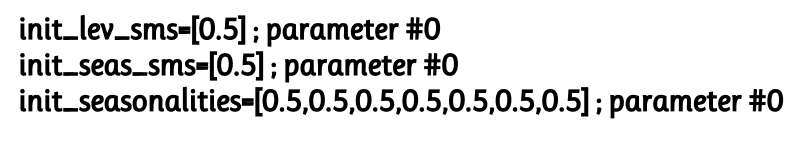

In [3]:
from IPython.display import Image
Image('drive/MyDrive/1.PNG') 

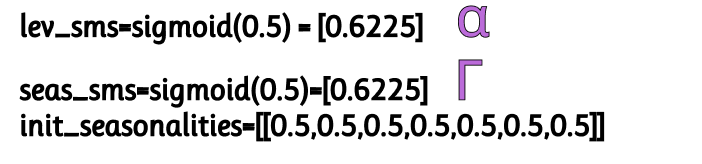

In [4]:
Image('drive/MyDrive/2.PNG')

In [ ]:
init_lev_sms=[]
init_lev_sms.append(nn.Parameter(torch.Tensor([0.5]),requires_grad=True))
print(init_lev_sms)

[Parameter containing:
tensor([0.5000], requires_grad=True)]


In [ ]:
init_seas_sms=[]
init_seas_sms.append(nn.Parameter(torch.Tensor([0.5]),requires_grad=True))
print(init_seas_sms)

[Parameter containing:
tensor([0.5000], requires_grad=True)]


In [ ]:
init_seasonalities=[]
init_seasonalities.append(nn.Parameter(torch.ones(7)*0.5,requires_grad=True))
print(init_seasonalities)

[Parameter containing:
tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
       requires_grad=True)]


In [ ]:
initt_lev_sms = nn.ParameterList(init_lev_sms)
print(initt_lev_sms)

ParameterList(  (0): Parameter containing: [torch.FloatTensor of size 1])


In [ ]:
initt_seas_sms = nn.ParameterList(init_seas_sms)
print(initt_seas_sms)

ParameterList(  (0): Parameter containing: [torch.FloatTensor of size 1])


In [ ]:
initt_seasonalities = nn.ParameterList(init_seasonalities)
print(initt_seasonalities)

ParameterList(  (0): Parameter containing: [torch.FloatTensor of size 7])


In [ ]:
for batch_num, (train, val, test, idx) in enumerate(dataloader):
    print(batch_num)
    print(train.shape)
    print(val.shape)
    print(test.shape)
    print(idx)

0
torch.Size([1, 478])
torch.Size([1, 14])
torch.Size([1, 124])
tensor([0])


In [ ]:
a=nn.Sigmoid()

In [ ]:
lev_sms = a(torch.stack([initt_lev_sms[idx] for idx in [0]]).squeeze(1)).to('cpu')

In [ ]:
print(lev_sms)

tensor([0.6225], grad_fn=<SigmoidBackward>)


In [ ]:
seas_sms = a(torch.stack([initt_seas_sms[idx] for idx in [0]]).squeeze(1)).to('cpu')

In [ ]:
print(seas_sms)

tensor([0.6225], grad_fn=<SigmoidBackward>)


In [ ]:
init_seasonalities = torch.stack([initt_seasonalities[idx] for idx in [0]]).squeeze(1)

In [ ]:
print(init_seasonalities)

tensor([[0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000]],
       grad_fn=<SqueezeBackward1>)


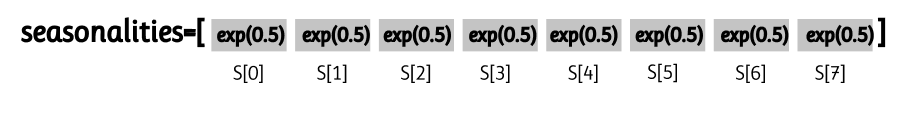

In [5]:
Image('drive/MyDrive/3.PNG')

In [ ]:
seasonalities = []
        # PRIME SEASONALITY
for i in range(7):
        seasonalities.append(torch.exp(init_seasonalities[:, i]))
        print(init_seasonalities[:,i])
seasonalities.append(torch.exp(init_seasonalities[:, 0]))
print(seasonalities)
print(len(seasonalities))
print(init_seasonalities[:,0])

tensor([0.5000], grad_fn=<SelectBackward>)
tensor([0.5000], grad_fn=<SelectBackward>)
tensor([0.5000], grad_fn=<SelectBackward>)
tensor([0.5000], grad_fn=<SelectBackward>)
tensor([0.5000], grad_fn=<SelectBackward>)
tensor([0.5000], grad_fn=<SelectBackward>)
tensor([0.5000], grad_fn=<SelectBackward>)
[tensor([1.6487], grad_fn=<ExpBackward>), tensor([1.6487], grad_fn=<ExpBackward>), tensor([1.6487], grad_fn=<ExpBackward>), tensor([1.6487], grad_fn=<ExpBackward>), tensor([1.6487], grad_fn=<ExpBackward>), tensor([1.6487], grad_fn=<ExpBackward>), tensor([1.6487], grad_fn=<ExpBackward>), tensor([1.6487], grad_fn=<ExpBackward>)]
8
tensor([0.5000], grad_fn=<SelectBackward>)


In [ ]:
train=train.float().to('cpu')
print(train.shape)

torch.Size([1, 478])


In [ ]:
print(train[:,0])

tensor([0.1935])


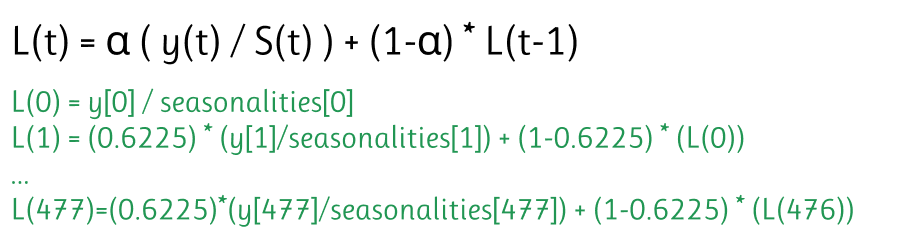

In [6]:
Image('drive/MyDrive/4.PNG')

In [ ]:
levs = []
log_diff_of_levels = []
levs.append(train[:, 0] / seasonalities[0].to('cpu'))

In [ ]:
print(levs)

[tensor([0.1174], grad_fn=<DivBackward0>)]


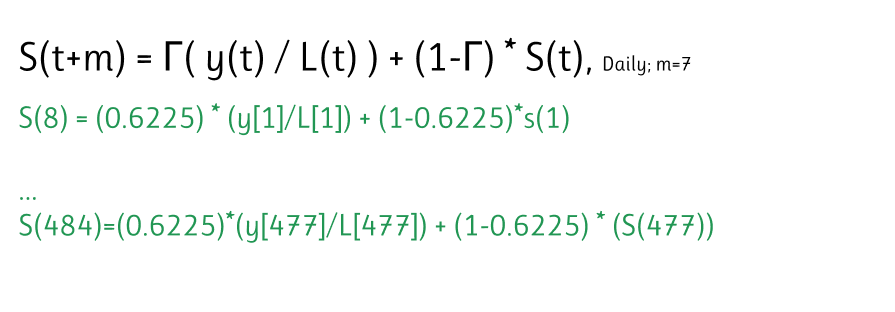

In [8]:
Image('drive/MyDrive/5.PNG')

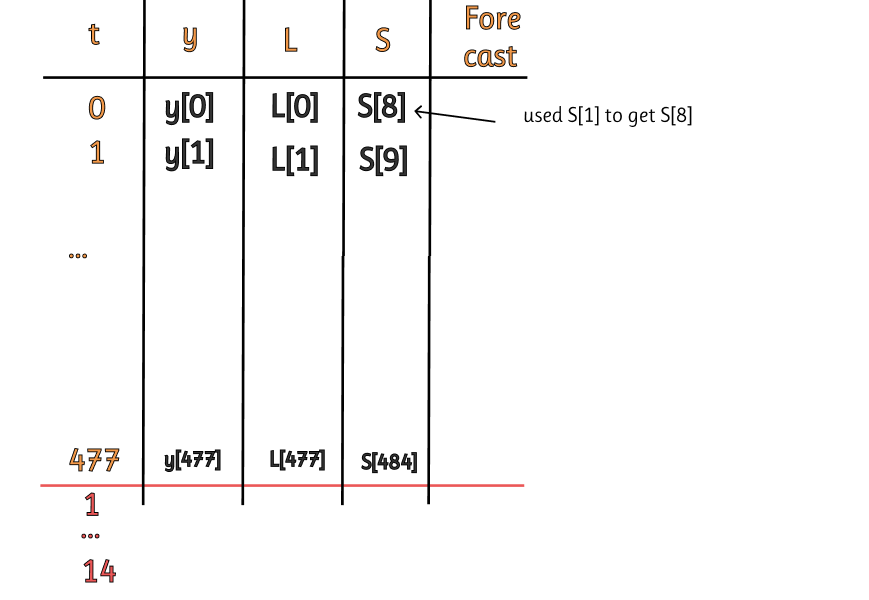

In [9]:
Image('drive/MyDrive/6.PNG')

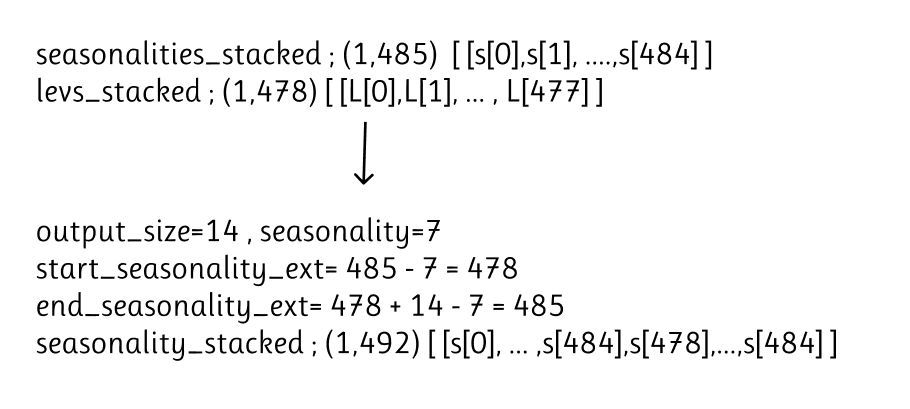

In [11]:
Image('drive/MyDrive/7.PNG')

In [ ]:
for i in range(1, 478):
            # CALCULATE LEVEL FOR CURRENT TIMESTEP TO NORMALIZE RNN
            new_lev = lev_sms* (train[:, i] / seasonalities[i]) + (1 - lev_sms)* levs[i - 1]
            levs.append(new_lev)
            # STORE DIFFERENCE TO PENALIZE LATER
            log_diff_of_levels.append(torch.log(new_lev / levs[i - 1]))

            # CALCULATE SEASONALITY TO DESEASONALIZE THE DATA FOR RNN
            seasonalities.append((seas_sms) * (train[:, i] / new_lev) + (1 - seas_sms)* seasonalities[i])
#len(seasonalities)=8+478
seasonalities_stacked = torch.stack(seasonalities).transpose(1, 0) # (486,1) -> (1,486)
levs_stacked = torch.stack(levs).transpose(1, 0)   #(479,1) -> (1,479)

RuntimeError: ignored

In [ ]:
 if self.config['output_size'] > self.config['seasonality']:
            start_seasonality_ext = seasonalities_stacked.shape[1] - self.config['seasonality']  #479
            end_seasonality_ext = start_seasonality_ext + self.config['output_size'] - self.config['seasonality']  #479+7
            seasonalities_stacked = torch.cat((seasonalities_stacked, seasonalities_stacked[:, start_seasonality_ext:end_seasonality_ext]),
                                              dim=1) #(1,486+7) -> (1,493)

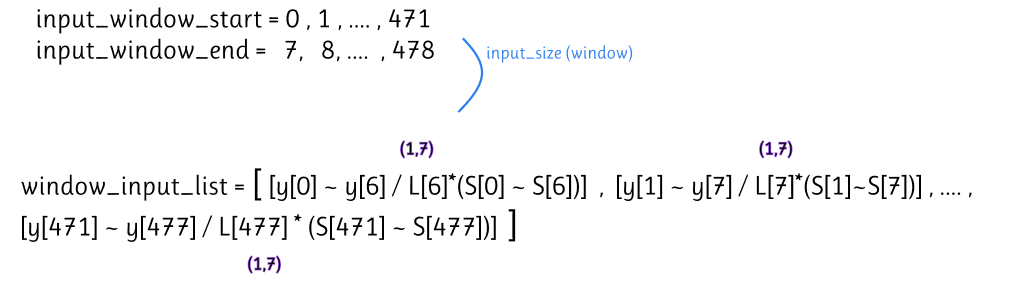

In [12]:
Image('drive/MyDrive/8.PNG')

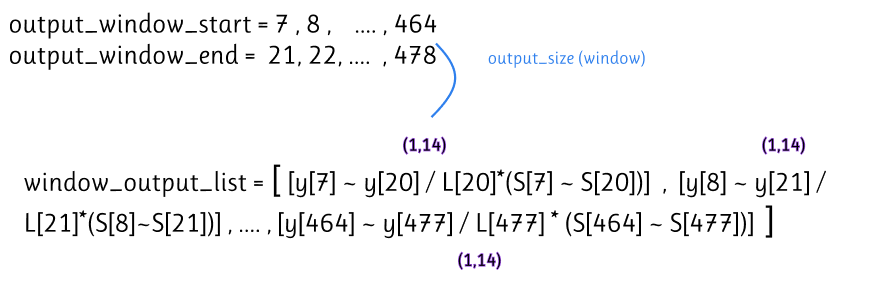

In [13]:
Image('drive/MyDrive/9.PNG')

In [ ]:
window_input_list = []
window_output_list = []
for i in range(6, 478):
            input_window_start = i + 1 - self.config['input_size']    #7-7=0,8-7=1,..,478-7=471
            input_window_end = i + 1 #7,8,...478

            train_deseas_window_input = train[:, input_window_start:input_window_end] / seasonalities_stacked[:,
                                                                                        input_window_start:input_window_end]
            train_deseas_norm_window_input = (train_deseas_window_input / levs_stacked[:, i].unsqueeze(1))
            #train_deseas_norm_cat_window_input = torch.cat((train_deseas_norm_window_input), dim=1)
            window_input_list.append(train_deseas_norm_window_input)

            output_window_start = i + 1
            output_window_end = i + 1 + self.config['output_size']

            if i < train.shape[1] - self.config['output_size']:
                train_deseas_window_output = train[:, output_window_start:output_window_end] / \
                                             seasonalities_stacked[:, output_window_start:output_window_end]
                train_deseas_norm_window_output = (train_deseas_window_output / levs_stacked[:, i].unsqueeze(1))
                window_output_list.append(train_deseas_norm_window_output)

window_input = torch.cat([i.unsqueeze(0) for i in window_input_list], dim=0)
window_output = torch.cat([i.unsqueeze(0) for i in window_output_list], dim=0)